In [1]:
import ghost
import pandas as pd
import os
import bids
import ants
from ghost.bids import unity_qa_process_subject
import seaborn as sns
import matplotlib.pyplot as plt
from ghost.phantom import Caliber137
from nilearn import plotting
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.oneway import anova_oneway
from tqdm import tqdm
import json

import os, sys

%load_ext autoreload
%autoreload 2

In [2]:
PROJDIR = '/home/em2876lj/Projects/QA/QA_paper/project'

notebook_path = f'{PROJDIR}/code/unity_qa_paper/notebooks/'
if notebook_path not in sys.path:
    sys.path.append(notebook_path)

from contrast_help import get_contrast_df, calc_contrast

In [3]:
subses = pd.read_csv(os.path.join(PROJDIR, 'code', 'slurm', 'all_sessions.txt'), delimiter=' ', names=['Subject', 'Session'])
layout = bids.BIDSLayout(root=PROJDIR+'/rawdata', derivatives=PROJDIR+'/derivatives')

In [4]:
df = get_contrast_df(subses, layout, recalculate=False)
df_con = calc_contrast(df)

/home/em2876lj/Projects/QA/QA_paper/project/code/unity_qa_paper/notebooks/contrast_help.py:72: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [5]:
df_con

,Subject,Session,Adult WM/GM Contrast,Neonatal WM/GM Contrast,SoftwareVersions
0,P0003,20230927164642,2.378782,1.540290,8.6.0
1,P0003,20230928180538,2.392356,1.563381,8.6.0
2,P0003,20231003162834,2.371398,1.581641,8.6.0
3,P0003,20231004161510,2.464106,1.600752,8.6.0
4,P0003,20231005183315,2.425850,1.562388,8.6.0
...,...,...,...,...,...
237,P0039,20240130082431,2.340154,1.491573,8.6.1
238,P0039,20240131094822,2.437430,1.478110,8.6.1
239,P0039,20240201080215,2.433892,1.509404,8.6.1
240,P0039,20240202093220,2.417158,1.485827,8.6.1


/local/slurmtmp.809178/ipykernel_3108763/1047115869.py:18: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



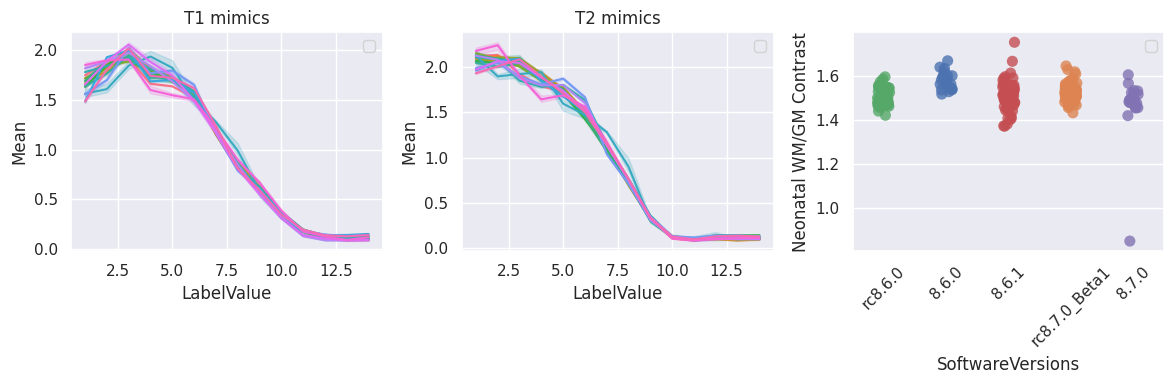

statistic = 12.76583626606144
pvalue = 5.775466721783709e-08
df = (4.0, np.float64(74.57572683436626))
df_num = 4.0
df_denom = 74.57572683436626
nobs_t = 242.0
n_groups = 5
means = [1.57634412 1.51257304 1.46634196 1.50812116 1.52207667]
nobs = [22. 80. 22. 51. 67.]
vars_ = [0.00162137 0.00361953 0.02062253 0.0013827  0.00170918]
use_var = unequal
welch_correction = True
tuple = (np.float64(12.76583626606144), np.float64(5.775466721783709e-08))


In [11]:
sns.set_theme()

fig, axes = plt.subplots(1,3, figsize=(12,4))

sns.lineplot(data=df[(df['Seg']=='T1') & (df['Run']==1)], x='LabelValue', y='Mean', hue='Subject', ax=axes[0])
axes[0].legend([])
axes[0].set_title('T1 mimics')

sns.lineplot(data=df[(df['Seg']=='T2') & (df['Run']==1)], x='LabelValue', y='Mean', hue='Subject', ax=axes[1])
axes[1].legend([])
axes[1].set_title('T2 mimics')

sns.stripplot(data=df_con, x='SoftwareVersions', 
                y='Neonatal WM/GM Contrast', ax=axes[2], 
                alpha=0.8, size=8, hue='SoftwareVersions', legend=True, 
                order=['rc8.6.0', '8.6.0', '8.6.1', 'rc8.7.0_Beta1', '8.7.0'])
axes[2].legend([])
axes[2].set_xticklabels(labels=axes[2].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

# One-way anova between sites
psnr_data = df_con['Neonatal WM/GM Contrast']
groups = df_con['SoftwareVersions']
res = anova_oneway(psnr_data, groups)
print(res)

In [9]:
# Combine with temperature
df_temp = pd.read_csv('/home/em2876lj/Projects/QA/QA_paper/project/derivatives/fisp_temperature_w0.csv')
df_temp['Temperature'] = 24-df_temp['n_black']

df['Temperature'] = None
for i,row in df.iterrows():
    df.at[i,'Temperature'] = df_temp[(df_temp['Subject']==row.Subject) & (df_temp['Session']==row.Session)].Temperature.values

df.Temperature = df.Temperature.astype('float64')

In [10]:
plt.figure()
sns.stripplot(data=df_con, x='Temperature', 
                y='Neonatal WM/GM Contrast', 
                alpha=0.8, size=8, hue='Temperature', legend=True)

# Ordinary least squares
y = df_con['Neonatal WM/GM Contrast']
y = df_con['Adult WM/GM Contrast']
X = sm.add_constant(df_con.Temperature)
mod = sm.OLS(y,X)
res = mod.fit()
print(res.summary())

ValueError: Could not interpret value `Temperature` for `x`. An entry with this name does not appear in `data`.

<Figure size 640x480 with 0 Axes>

In [44]:
seg = 'T1'
con_mat = np.zeros((14,14))
for id1 in range(1,15):
    for id2 in range(id1, 15):
        for sub in df_master.Subject.unique():
            sub_df = df_master[(df_master.Subject == sub) & (df_master.Run == 1)]
            for ses in sub_df.Session.unique():
                ses_df = sub_df[sub_df.Session==ses]

,LabelValue,Mean,Min,Max,Variance,Subject,Session,Run,Seg,SoftwareVersions,Temperature
0,1.0,1.748789,122.0,3734.0,672742.573721,P0003,20230927164642,1,T1,8.6.0,23.0
1,2.0,1.914507,815.0,3919.0,399401.321908,P0003,20230927164642,1,T1,8.6.0,23.0
2,3.0,1.891630,1264.0,3653.0,281604.249372,P0003,20230927164642,1,T1,8.6.0,23.0
3,4.0,1.657146,309.0,3417.0,444708.785546,P0003,20230927164642,1,T1,8.6.0,23.0
4,5.0,1.639578,870.0,3829.0,331983.782666,P0003,20230927164642,1,T1,8.6.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...
13547,10.0,0.114403,55.0,204.0,1360.039057,P0039,20240207083415,2,T2,8.6.1,24.0
13548,11.0,0.090736,33.0,170.0,1088.213033,P0039,20240207083415,2,T2,8.6.1,24.0
13549,12.0,0.115033,28.0,262.0,2990.443785,P0039,20240207083415,2,T2,8.6.1,24.0
13550,13.0,0.154470,39.0,329.0,8017.513462,P0039,20240207083415,2,T2,8.6.1,24.0


In [66]:
df[(df['LabelValue'].isin([1,2])) & (df['Seg']=='T1') & (df['Run']==1)].groupby(by='Session').sum()

,LabelValue,Mean,Min,Max,Variance,Subject,Run,Seg,SoftwareVersions,Temperature
Session,,,,,,,,,,
20230619164159,3.0,3.502369,987.0,7550.0,8.357540e+05,P0009P0009,2,T1T1,rc8.6.0rc8.6.0,44.0
20230621095657,3.0,3.532937,1619.0,7727.0,7.672399e+05,P0009P0009,2,T1T1,rc8.6.0rc8.6.0,42.0
20230621132858,3.0,3.562388,464.0,7606.0,1.035725e+06,P0013P0013,2,T1T1,rc8.6.0rc8.6.0,46.0
20230622093334,3.0,3.497310,1340.0,7771.0,8.528589e+05,P0009P0009,2,T1T1,rc8.6.0rc8.6.0,42.0
20230623094531,3.0,3.457481,1287.0,7674.0,8.549437e+05,P0009P0009,2,T1T1,rc8.6.0rc8.6.0,42.0
...,...,...,...,...,...,...,...,...,...,...
20240417153058,3.0,3.155750,869.0,6525.0,7.717833e+05,P0020P0020,2,T1T1,8.7.08.7.0,40.0
20240418144739,3.0,3.045885,1096.0,6384.0,8.065923e+05,P0020P0020,2,T1T1,8.7.08.7.0,40.0
20240419161029,3.0,3.865345,1555.0,6065.0,5.051258e+05,P0020P0020,2,T1T1,8.7.08.7.0,40.0
